In [1]:
import sys
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [161]:
feature_id = 275

In [162]:
RT_LIMIT_LOWER = 4340
RT_LIMIT_UPPER = 4580

In [163]:
BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)
SUMMED_REGIONS_DATABASE = '{}/HeLa_20KInt-features-{}-{}.sqlite'.format(BASE_NAME, feature_id, feature_id)

In [164]:
def standard_deviation(mz):
    instrument_resolution = 40000.0
    return ((mz / instrument_resolution) / 2.35482)

In [165]:
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
feature_df = pd.read_sql_query("select * from feature_list where feature_id = {}".format(feature_id), db_conn)
db_conn.close()

In [166]:
feature_df

,feature_id,charge_state,monoisotopic_mass,feature_centroid_scan,feature_centroid_rt,feature_centroid_mz,feature_start_rt,feature_end_rt,feature_scan_lower,feature_scan_upper,...,base_peak_scan_lower,base_peak_scan_upper,base_peak_centroid_rt,base_peak_std_dev_rt,base_peak_rt_lower,base_peak_rt_upper,base_peak_centroid_mz,base_peak_std_dev_mz,base_peak_mz_lower,base_peak_mz_upper
0,275,4,3606.693163,470.785061,4423.619685,902.993167,4411.289878,4433.733502,462,482,...,462,482,4423.405274,3.07336,4413.653028,4433.733502,902.93133,0.007463,902.8881,902.973386


In [167]:
charge_state = feature_df.iloc[0].charge_state

In [168]:
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
peaks_df = pd.read_sql_query("select * from summed_ms1_regions where feature_id = {} order by peak_id".format(feature_id), db_conn)
peaks_df["marker_size"] = (((np.log(peaks_df.intensity)-5)*2)**2)*4
db_conn.close()

In [169]:
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
unallocated_points_df = pd.read_sql_query("select * from summed_ms1_regions", db_conn)
unallocated_points_df["marker_size"] = (((np.log(unallocated_points_df.intensity)-5)*2)**2)*4
db_conn.close()

In [170]:
unallocated_points_df.head()

,feature_id,point_id,mz,retention_time_secs,scan,intensity,number_frames,peak_id,feature_point,marker_size
0,275,1,902.930788,4424.021660,462,17098,2,1,275|1,360.501123
1,275,2,902.677769,4425.924879,462,12491,3,2,275|2,314.390299
2,275,3,903.181619,4426.218847,462,8792,2,3,275|3,266.551010
3,275,4,903.433224,4424.889720,462,3909,1,4,275|4,171.194915
4,275,5,903.934599,4424.848023,462,735,1,7,275|5,40.953370


In [171]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

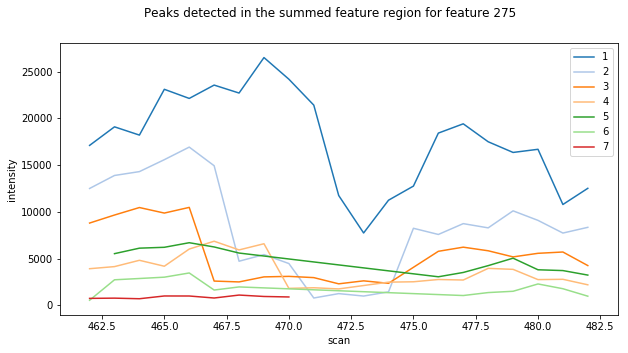

In [172]:
fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax.plot(group.scan, group.intensity, color=tableau20[i], label=name)
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
fig.set_figheight(5)
fig.set_figwidth(10)
plt.suptitle('Peaks detected in the summed feature region for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

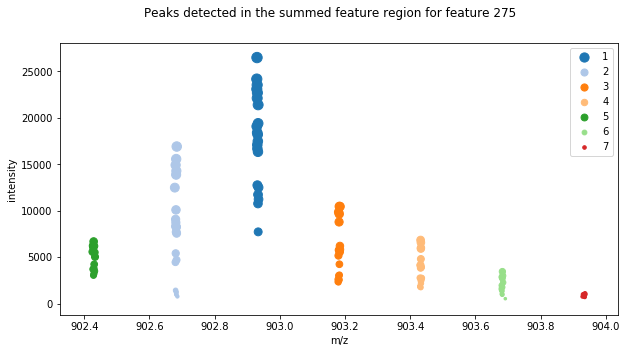

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# plot the detected peaks
fig, ax = plt.subplots()
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax.scatter(group.mz, group.intensity, marker='.', color=tableau20[i], s=group.marker_size, label=name)

plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('intensity')
fig.set_figheight(5)
fig.set_figwidth(10)
plt.suptitle('Peaks detected in the summed feature region for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

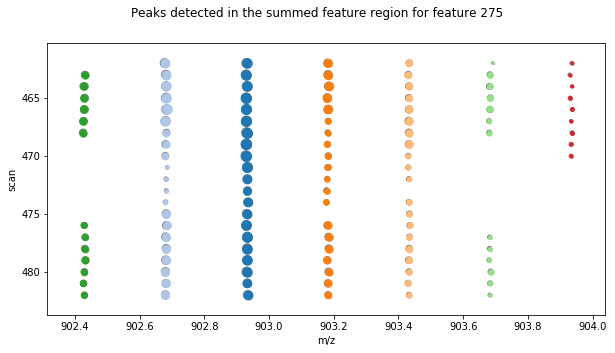

In [174]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# plot the unallocated points
ax.scatter(unallocated_points_df.mz, unallocated_points_df.scan, marker='.', color='grey', s=unallocated_points_df.marker_size)

# plot the detected peaks
groups = peaks_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    for data_point in group.itertuples():
        markersize = (((np.log(data_point.intensity)-5)*2)**2)*4
        ax.scatter(data_point.mz, data_point.scan, marker='.', color=tableau20[i], s=markersize, label=name)

plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.suptitle('Peaks detected in the summed feature region for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

In [175]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [176]:
mzs = peaks_df.groupby('peak_id').apply(wavg, "mz", "intensity").reset_index(name='mz_centroid')

In [177]:
mzs

,peak_id,mz_centroid
0,1,902.931330
1,2,902.681482
2,3,903.182061
3,4,903.432266
4,5,902.429077
5,6,903.682333
6,7,903.933267


In [178]:
intensities = peaks_df.groupby('peak_id').intensity.sum().reset_index(name='summed_intensity')

In [179]:
intensities

,peak_id,summed_intensity
0,1,372990
1,2,175142
2,3,109105
3,4,73732
4,5,62885
5,6,25070
6,7,7863


In [180]:
cluster_df = pd.concat([mzs, intensities.summed_intensity], axis=1)

In [181]:
cluster_df

,peak_id,mz_centroid,summed_intensity
0,1,902.931330,372990
1,2,902.681482,175142
2,3,903.182061,109105
3,4,903.432266,73732
4,5,902.429077,62885
5,6,903.682333,25070
6,7,903.933267,7863


In [182]:
cluster_df.sort_values(by='mz_centroid', inplace=True)

In [183]:
cluster_df

,peak_id,mz_centroid,summed_intensity
4,5,902.429077,62885
1,2,902.681482,175142
0,1,902.931330,372990
2,3,903.182061,109105
3,4,903.432266,73732
5,6,903.682333,25070
6,7,903.933267,7863


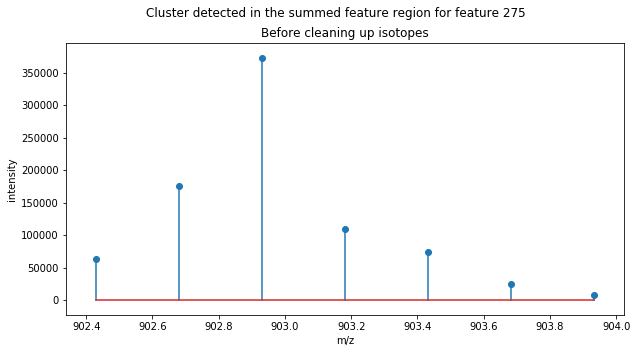

In [184]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
fig.set_figheight(5)
fig.set_figwidth(10)
plt.suptitle('Cluster detected in the summed feature region for feature {}'.format(feature_id))
plt.title('Before cleaning up isotopes')
plt.show()

In [185]:
cluster_df.reset_index(drop=True, inplace=True)
base_peak_index = cluster_df.summed_intensity.idxmax()
cluster_df

,peak_id,mz_centroid,summed_intensity
0,5,902.429077,62885
1,2,902.681482,175142
2,1,902.931330,372990
3,3,903.182061,109105
4,4,903.432266,73732
5,6,903.682333,25070
6,7,903.933267,7863


In [186]:
DELTA_MZ = 1.003355     # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
PROTON_MASS = 1.007276  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.

In [187]:
expected_spacing = DELTA_MZ / charge_state
expected_spacing

0.25083875

In [188]:
base_peak_mz = cluster_df.iloc[base_peak_index].mz_centroid
spacing_from_base = abs(cluster_df.mz_centroid - base_peak_mz) % expected_spacing
spacing_from_base

0    0.000575
1    0.249848
2    0.000000
3    0.250731
4    0.250097
5    0.249326
6    0.249422
Name: mz_centroid, dtype: float64

In [189]:
base_peak_mz

902.9313295915946

In [190]:
# drop indices that are not within 4*stddev of an isotope
std_dev = standard_deviation(base_peak_mz)
close_to_next_isotope = (abs(spacing_from_base - expected_spacing) < (standard_deviation(base_peak_mz) * 4))
close_to_next_isotope

0    False
1     True
2    False
3     True
4     True
5     True
6     True
Name: mz_centroid, dtype: bool

In [191]:
close_to_this_isotope = spacing_from_base < (standard_deviation(base_peak_mz) * 4)
close_to_this_isotope

0     True
1    False
2     True
3    False
4    False
5    False
6    False
Name: mz_centroid, dtype: bool

In [192]:
indexes_to_drop = ~(close_to_next_isotope | close_to_this_isotope)
indexes_to_drop

0    False
1    False
2    False
3    False
4    False
5    False
6    False
Name: mz_centroid, dtype: bool

In [193]:
cluster_df.drop(cluster_df.index[indexes_to_drop], inplace=True)
cluster_df.reset_index(drop=True, inplace=True)

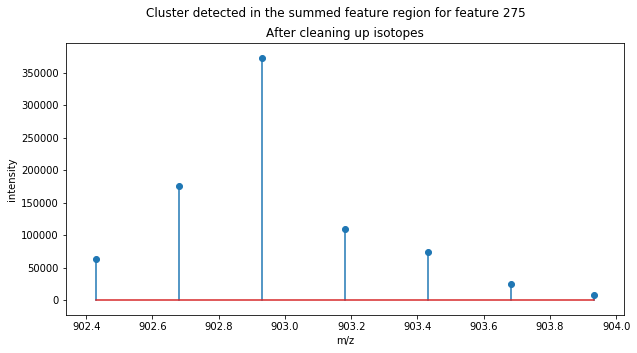

In [194]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
fig.set_figheight(5)
fig.set_figwidth(10)
plt.suptitle('Cluster detected in the summed feature region for feature {}'.format(feature_id))
plt.title('After cleaning up isotopes')
plt.show()

In [195]:
base_peak_index = cluster_df.summed_intensity.idxmax()
base_peak_mz = cluster_df.iloc[base_peak_index].mz_centroid

In [196]:
indexes_to_drop = abs(cluster_df.mz_centroid.diff() - expected_spacing) > 0.5
indexes_to_drop

0    False
1    False
2    False
3    False
4    False
5    False
6    False
Name: mz_centroid, dtype: bool

In [197]:
cluster_df.drop(cluster_df.index[indexes_to_drop], inplace=True)
cluster_df.reset_index(drop=True, inplace=True)

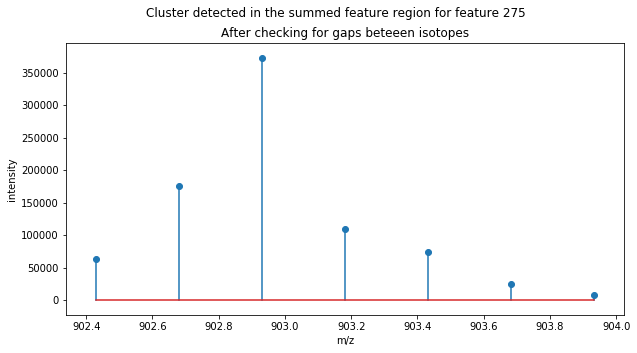

In [198]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
fig.set_figheight(5)
fig.set_figwidth(10)
plt.suptitle('Cluster detected in the summed feature region for feature {}'.format(feature_id))
plt.title('After checking for gaps beteeen isotopes')
plt.show()

In [199]:
# From "A Model-Based Method for the Prediction of the Isotopic Distribution of Peptides", Dirk Valkenborg, 
# Ivy Jansen, and Tomasz Burzykowski, J Am Soc Mass Spectrom 2008, 19, 703–712

MAX_NUMBER_OF_SULPHUR_ATOMS = 3
MAX_NUMBER_OF_PREDICTED_RATIOS = 6

S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S0_r[1] = [-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684]
S0_r[2] = [0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412]
S0_r[3] = [0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939]
S0_r[4] = [-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979]
S0_r[5] = [-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742]
S0_r[6] = [0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180]

S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S1_r[1] = [-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489]
S1_r[2] = [0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601]
S1_r[3] = [0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027]
S1_r[4] = [0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815]
S1_r[5] = [-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163]
S1_r[6] = [0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940]

S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=object)
S2_r[1] = [-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070]
S2_r[2] = [0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884]
S2_r[3] = [0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139]
S2_r[4] = [0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786]
S2_r[5] = [-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608]
S2_r[6] = [-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598]

model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=object)
model_params[0] = S0_r
model_params[1] = S1_r
model_params[2] = S2_r

# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    ratio = 0.0
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio


In [200]:
peak_ratio(1500,1,0)

0.80707722607587

In [201]:
PROTON_MASS

1.007276

In [202]:
charge_state

4.0

In [203]:
# find the combination of mono index and sulphurs that gives the smallest total height ratio error
minimum_error = sys.float_info.max
minimum_error_sulphur = None
minimum_error_mono_index = None

for test_mono_index in range(0,base_peak_index+1):  # consider moving it up to the base peak (but not beyond)
    test_monoisotopic_mass = (cluster_df.loc[test_mono_index].mz_centroid - PROTON_MASS) * charge_state
    for sulphur in range(0,MAX_NUMBER_OF_SULPHUR_ATOMS):
        # find the total peak height ratio error for the mono in this position with this many sulphur atoms
        error = 0
        number_of_peaks_to_test = min(MAX_NUMBER_OF_PREDICTED_RATIOS, len(cluster_df)-test_mono_index)
        for peak_number in range(1,number_of_peaks_to_test):
            predicted_ratio = peak_ratio(test_monoisotopic_mass, peak_number=peak_number, number_of_sulphur=sulphur)
            if predicted_ratio > 0:
                observed_ratio = cluster_df.loc[test_mono_index+peak_number].summed_intensity / cluster_df.loc[test_mono_index+peak_number-1].summed_intensity
                error += (predicted_ratio - observed_ratio)**2 / predicted_ratio
            print("mono index {}, peak {}, mono mass {}, predicted ratio {}, actual ratio {}".format(test_mono_index,peak_number,test_monoisotopic_mass,predicted_ratio,observed_ratio))
        # if the error for the mono in this position is the lowest so far, record it
        if error < minimum_error:
            minimum_error = error
            minimum_error_sulphur = sulphur
            minimum_error_mono_index = test_mono_index
        print("error - test mono {}, S {}: {}".format(test_mono_index, sulphur, error))
monoisotopic_mass = (cluster_df.loc[minimum_error_mono_index].mz_centroid - PROTON_MASS) * feature_df.loc[0].charge_state
print("best mono index: {}, sulphurs {}, monoisotopic mass {}, minimum error {}".format(minimum_error_mono_index, minimum_error_sulphur, monoisotopic_mass, minimum_error))

mono index 0, peak 1, mono mass 3605.68720337, predicted ratio 1.95743803222, actual ratio 2.78511568737
mono index 0, peak 2, mono mass 3605.68720337, predicted ratio 1.02573135964, actual ratio 2.12964337509
mono index 0, peak 3, mono mass 3605.68720337, predicted ratio 0.712658733327, actual ratio 0.292514544626
mono index 0, peak 4, mono mass 3605.68720337, predicted ratio 0.553840532675, actual ratio 0.675789377205
mono index 0, peak 5, mono mass 3605.68720337, predicted ratio 0.456903274753, actual ratio 0.340015190148
error - test mono 0, S 0: 1.84247298909
mono index 0, peak 1, mono mass 3605.68720337, predicted ratio 1.94810187639, actual ratio 2.78511568737
mono index 0, peak 2, mono mass 3605.68720337, predicted ratio 1.04224524013, actual ratio 2.12964337509
mono index 0, peak 3, mono mass 3605.68720337, predicted ratio 0.737273609746, actual ratio 0.292514544626
mono index 0, peak 4, mono mass 3605.68720337, predicted ratio 0.578306786503, actual ratio 0.675789377205
mono 

In [204]:
cluster_df = cluster_df.loc[minimum_error_mono_index:].copy()

In [205]:
cluster_df.reset_index(drop=True, inplace=True)

In [ ]:
cluster_df

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.stem(cluster_df.mz_centroid, cluster_df.summed_intensity)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.margins(0.06)
fig.set_figheight(5)
fig.set_figwidth(10)
plt.suptitle('Cluster detected in the summed feature region for feature {}'.format(feature_id))
plt.title('After determining monoisotopic peak')
plt.show()

In [ ]:
expected_spacing

In [ ]:
cluster_df['mz_mod'] = cluster_df.mz_centroid - (cluster_df.index*expected_spacing)

In [ ]:
cluster_df

In [ ]:
cluster_mz_centroid = wavg(cluster_df, "mz_mod", "summed_intensity")
cluster_mz_centroid

In [ ]:
cluster_summed_intensity = cluster_df.summed_intensity.sum()
cluster_summed_intensity

In [ ]:
monoisotopic_mass = (cluster_mz_centroid - PROTON_MASS) * charge_state
monoisotopic_mass